# ADAM-DS data retrieve and image mosaicking example

Here we use Python ADAM API to access imagery data from the data store, do some data resampling for the sake of exercise -- since the images at hand are too large for web services and this example -- to eventually merge them into a _mosaic_.

In [1]:
import adamapi

## Authenticate user

First thing we have to do is to authenticate our user. This is easily done once connected to ADAM explorer, in dashboard.

In [2]:
from adamapi import Auth

a = Auth()
a.setKey("7OSyxWA_tZgTEo66g4NTkDPQGLAGWuNa6oJ_Nx7dWjY")
a.setAdamCore("https://explorer-space.adamplatform.eu/")
a.authorize()

{'expires_at': '2021-06-07T13:51:19.066Z',
 'access_token': '07e93ed004be439da258ab762b25eaaa',
 'refresh_token': '4d268c4c0cf943a284c02d9207a02d73',
 'expires_in': 3600}

## Query available datasets

Supposing we don't know the available datasets, we can easily query the data store to list available options.

In [3]:
from adamapi import Datasets
import json

datasets = Datasets(a)
items = datasets.getDatasets()

print(json.dumps(items, indent=2))

{
  "type": "FeatureCollection",
  "properties": {
    "totalResults": 1,
    "itemsPerPage": 1,
    "maxRecords": 10,
    "page": 0
  },
  "content": [
    {
      "datasetId": "58592:MRO_CTX",
      "title": "Mars Reconnaissance Orbiter - Context Camera",
      "description": "Products from Context Camera instrument in Mars Reconnaissance Orbiter",
      "startDate": "2006-03-24T04:41:07Z",
      "endDate": "2020-08-31T18:19:37Z"
    }
  ]
}


Here, for instance, `MRO_CTX` is available for our public access... let's see how many data products are in there.

In [4]:
ctx_dataset = datasets.getDatasets( '58592:MRO_CTX' )

print(f"Number of images: {ctx_dataset['numberOfRecords']}")

Number of images: 6495


## Query data products inside bounding-box

Considering we have a location of interest where we want to get images from, we can ask ADAM for that.
Here we are going to query the bounding-box previously used to demonstrate the ADAM explorer:

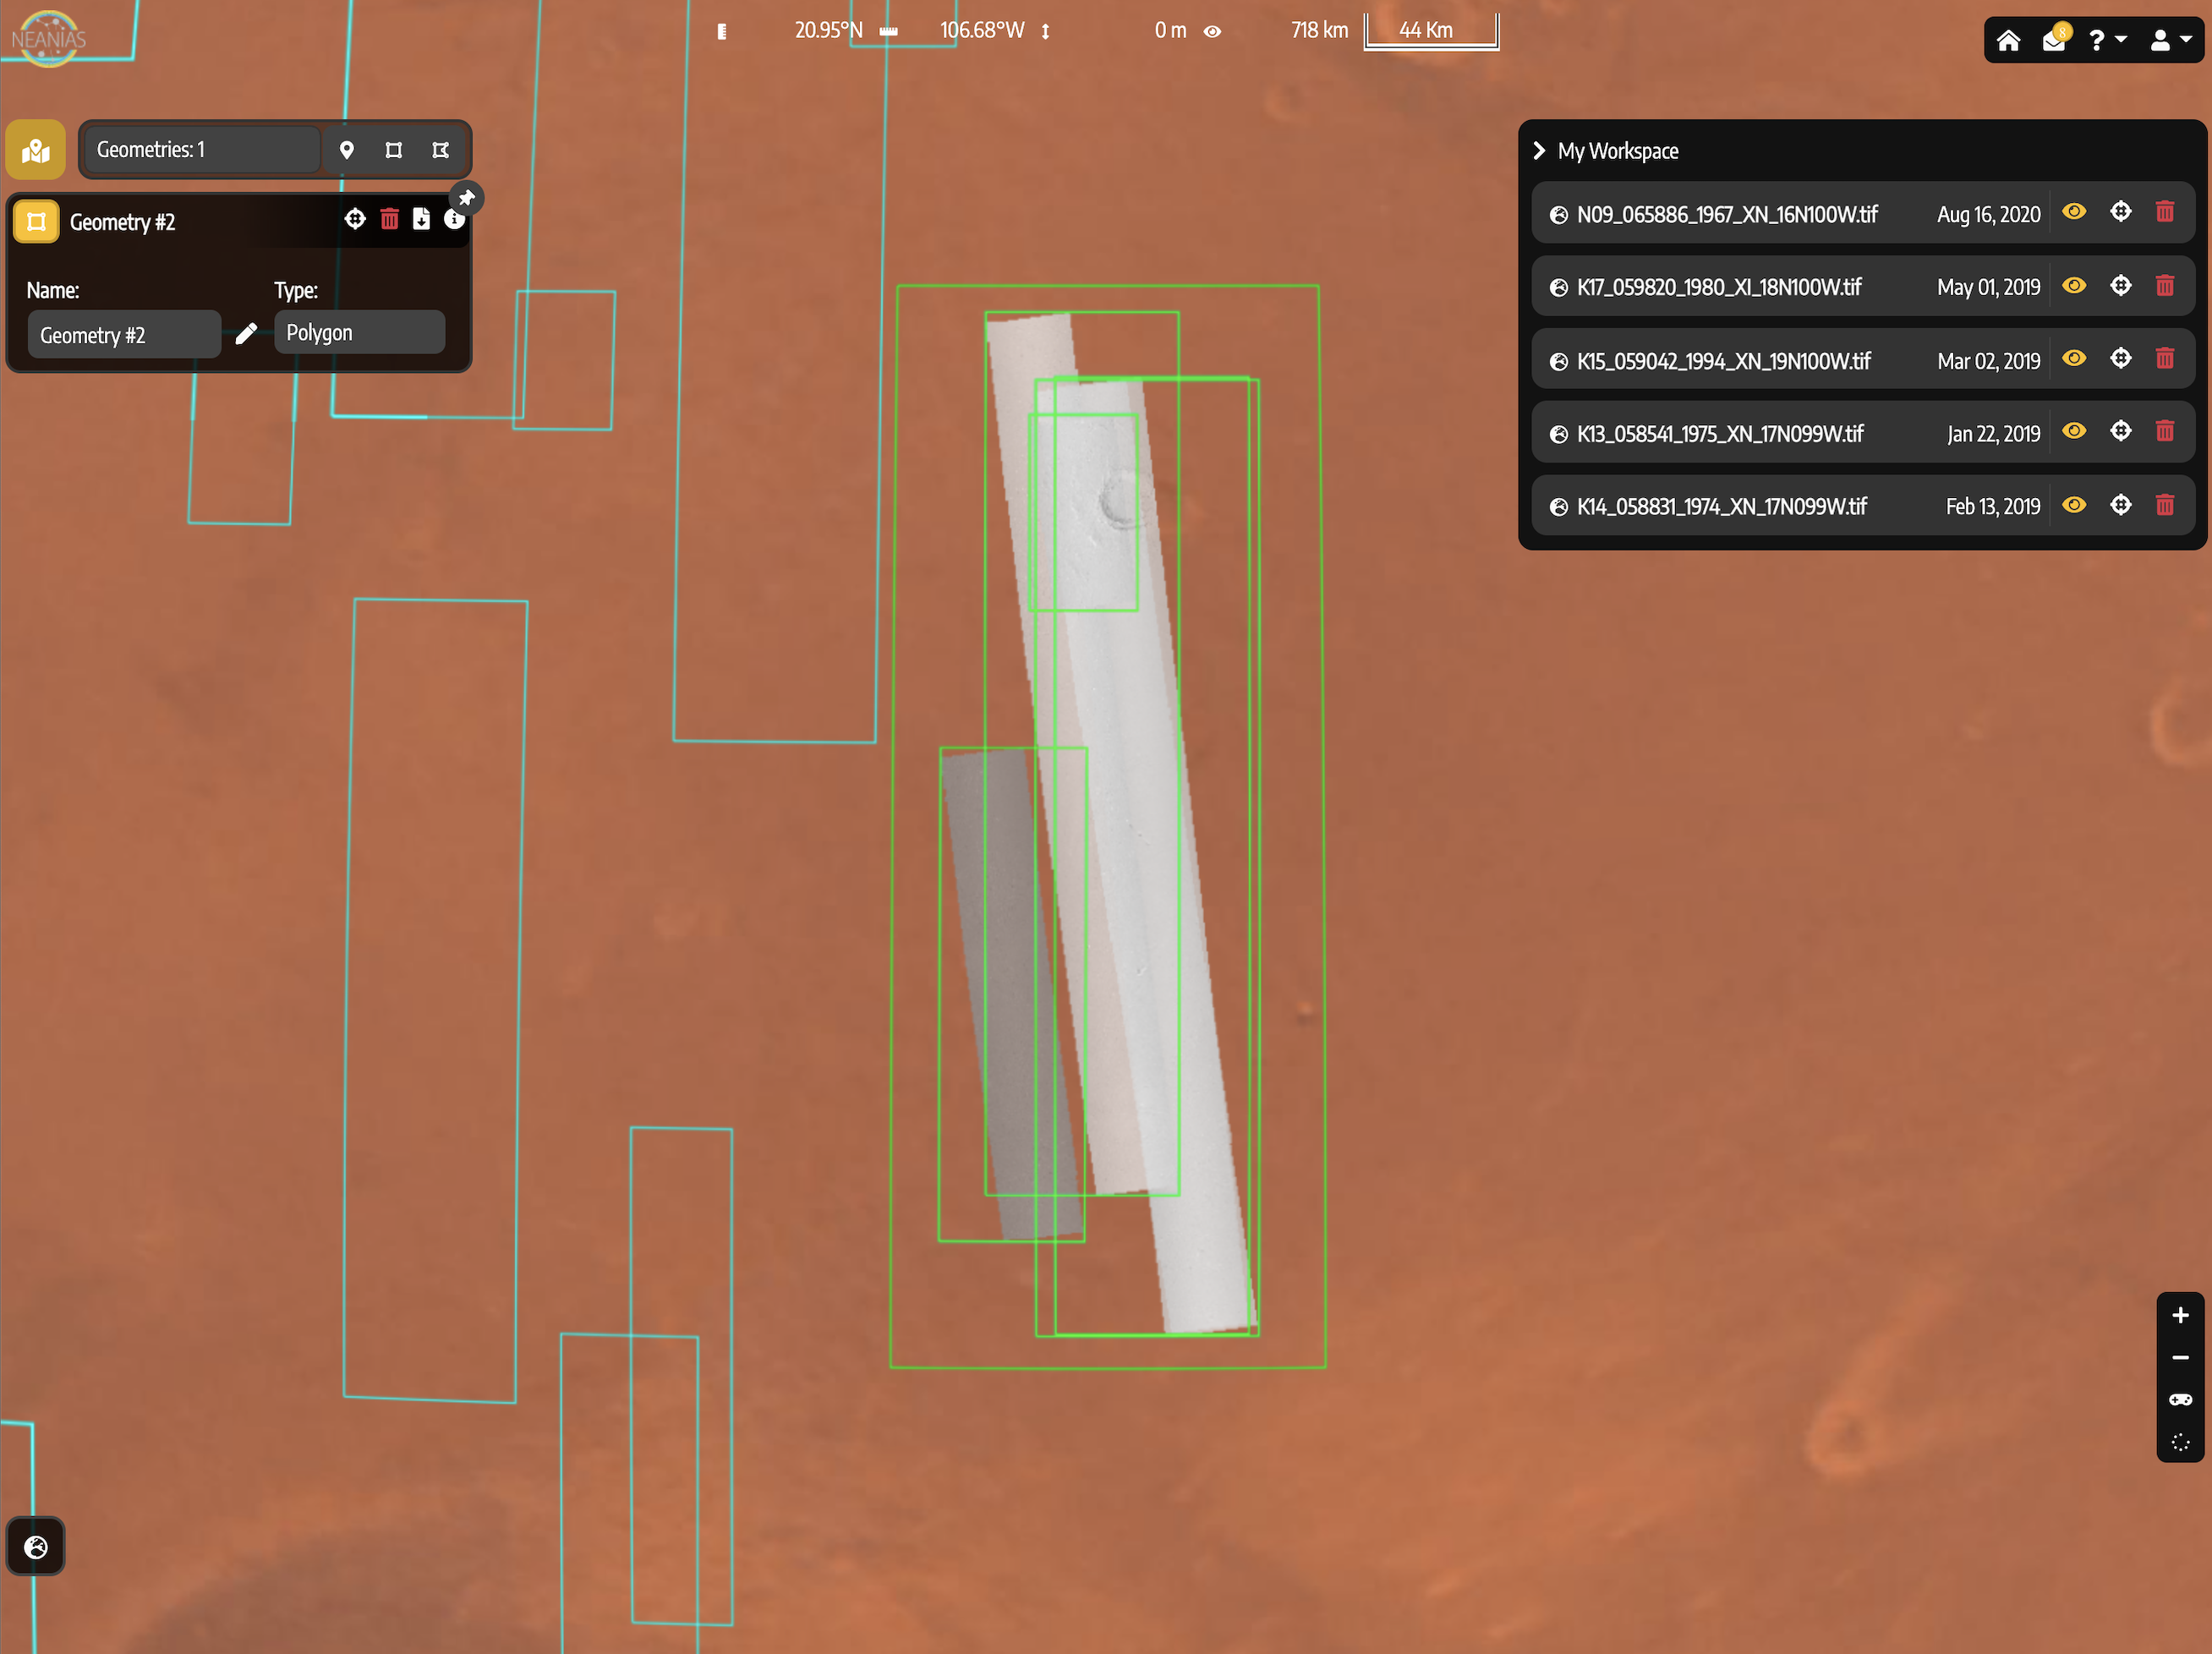

The bounding-box containing this set of interest/highlighted products is given below in standard GeoJSON format.

In [5]:
from adamapi import Search

datasetId = '58592:MRO_CTX'

search_result = Search(a).getProducts(
    datasetId,
    geometry = {
        "type": "Polygon",
        "coordinates": [[
            [-101,14],
            [-98,14],
            [-98,21],
            [-101,21],
            [-101,14]
        ]]
    },
    startIndex = 0,
    maxRecords = 10)

print("Number of products found:", len(search_result['content']))

Number of products found: 10


## Visualize queried data products

Let's have a quick look of the data products -- their footprints -- we just queried.
Sure enough, such plot is a subset of what we had/have from ADAM-Explorer.

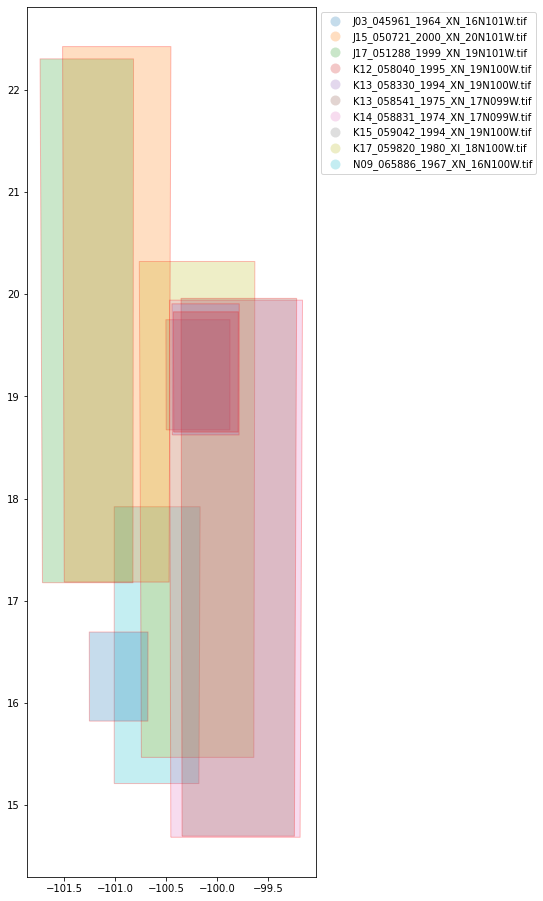

In [6]:
%matplotlib inline

import geopandas
from shapely.geometry import shape

_gd = {'productId':[], 'geometry':[]}
for p in search_result['content']:
    _gd['productId'].append(p['productId'])
    _gd['geometry'].append(shape(p['geometry']['geometries'][0]))
    
gdf = geopandas.GeoDataFrame(_gd)

gdf.plot(alpha=0.25, edgecolor='red', legend=True, column='productId', legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1)}, 
         figsize=(24,16));

## Download a sub-sample to mosaic

Now that we have identify a set of iamges/region of interest, for the sake of this exercise let's select a couple of them for masicking and visualization:
```
- K13_058541_1975_XN_17N099W.tif
- K17_059820_1980_XI_18N100W.tif
```

In [7]:
products = [
    'K13_058541_1975_XN_17N099W.tif',
    'K17_059820_1980_XI_18N100W.tif'
]

In [8]:
import shutil
from pathlib import Path

datapath = Path('data')
outpath = datapath / 'adamapiresults'

zips = []
for product in products:
    _tif = outpath / product
    _zip = _tif.with_suffix('.zip')
    if _zip.exists():
        print(f"Product '{product}' already downloaded")
        zips.append(_zip)
        continue
    print(f"Requesting '{product}'")
    
    # ----------------------
    # Here we efectively request the data to ADAM...the rest is just boilerplating for writing/checking downloads
    _out = adam.GetData(a).getData(datasetId, productId=product, outputFname=_zip.as_posix())
    # ----------------------
    
    assert _out == _zip.as_posix()
    zips.append(_zip)

tiffs = []
for _zip in zips:
    _tif = _zip.with_suffix('.tif')
    shutil.unpack_archive(_zip, 'adamapiresults')
    tiffs.append(_tif)
    
tiffs

Product 'K13_058541_1975_XN_17N099W.tif' already downloaded
Product 'K17_059820_1980_XI_18N100W.tif' already downloaded


[PosixPath('data/adamapiresults/K13_058541_1975_XN_17N099W.tif'),
 PosixPath('data/adamapiresults/K17_059820_1980_XI_18N100W.tif')]

## Resample/rescale images

Since the iamges we are working are quite big, let's resample them to make things faster and web-friendly.

In [9]:
def rescale(filename_in, filename_out, factor=0.5):
    """
    Resample data for faster processing. Rescale to HALF the resolution by default.
    """
    import rasterio
    from rasterio.enums import Resampling
    
    with rasterio.open(filename_in) as src:

        height = int(src.height * factor)
        width = int(src.width * factor)
        transform = src.transform * src.transform.scale(
                    (src.width / width),
                    (src.height / height)
        )

        # resample data to target shape
        data = src.read(
            out_shape=(src.count, height, width),
            resampling=Resampling.bilinear
        )
        data[data<=src.nodata] = src.nodata

        # copy src metadata, update as necessary for 'dst'
        kwargs = src.meta.copy()
        kwargs.update({
            'transform': transform,
            'width': width,
            'height': height
        })

        # reproject "src" to "dst"
        with rasterio.open(filename_out, 'w', **kwargs) as dst:
            for i, band in enumerate(data, 1):
                dst.write(band, i)

        return filename_out

In [10]:
resampled_tiffs = []
for _tif in tiffs:
    print(f"Resampling image: {_tif}..")
    _res = _tif.with_suffix('.resampled.tif')
    _out = rescale(_tif, _res)
    assert _out == _res
    resampled_tiffs.append(_res)
print(f"Done.")

Resampling image: data/adamapiresults/K13_058541_1975_XN_17N099W.tif..
Resampling image: data/adamapiresults/K17_059820_1980_XI_18N100W.tif..
Done.


## Finally, Mosaic them!

Now that we have our sample images, downloaded and resampled to suit our example, let's merge them into a mosaic.

In [11]:
import rasterio
from rasterio.merge import merge

output = outpath / 'mosaic.tif'

with rasterio.open(resampled_tiffs[0]) as src:
    meta = src.meta.copy()

# The merge function returns a single array and the affine transform info
arr, out_trans = merge(resampled_tiffs[::-1])

meta.update({
    "driver": "GTiff",
    "height": arr.shape[1],
    "width": arr.shape[2],
    "transform": out_trans
})

# Write the mosaic raster to disk
with rasterio.open(output, "w", **meta) as dest:
    dest.write(arr)

print(f"Mosaic output '{output}' complete")

Mosaic output 'data/adamapiresults/mosaic.tif' complete


## Visualize output mosaic

Mosaic succesfully generate, let's quick visualize it using Python matplotlib.

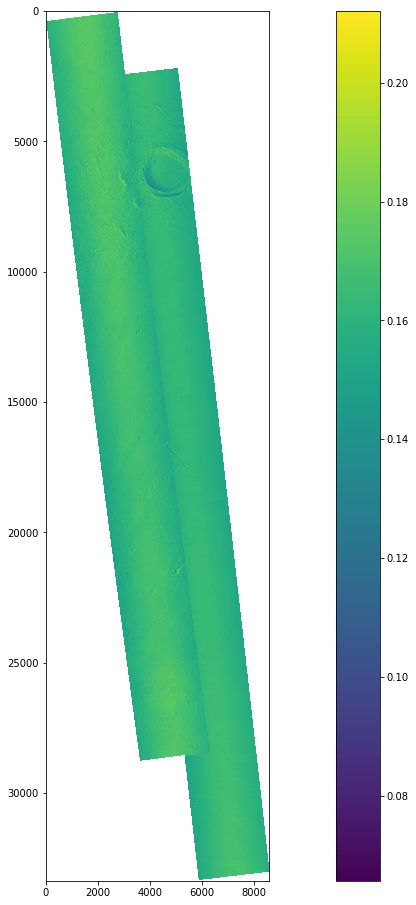

In [12]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np

with rasterio.open(output) as tif:
    img = tif.read(1)
    img[img<=tif.nodata] = np.nan

plt.subplots(figsize=(24,16))
plt.imshow(img, cmap = 'viridis');
plt.colorbar();